# Sanity check: model which predicts AMD versus control OCT

In [1]:
from buildDataset import *
%matplotlib inline
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
root_path =      DATAPATHS["preprocessed"]
from sklearn.model_selection import KFold

from sklearn.metrics import PrecisionRecallDisplay

c:\Users\line\Desktop\Mauro\2_Preprocessing_Code\amd\prl\dataset.py:8: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology import selem


In [2]:
X,y = getBalancedXYData(mode = 'raw',normmode = 'EQ-hist')
print(X.shape)
print(y.shape)
print(768*14*18)

(193536, 70)
(193536,)
193536


In [3]:
# X_OCT: (N, W, H, C) 
# y_labels: 1 if AMD, 0 if control.
X_OCT = X.reshape((14*18, 768*X.shape[1]))
y_labels = np.zeros((14*18))
for i in range(28, 28+14):
    y_labels[i::42] = 1
print(y_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# Create a cv that specifies the folds of my dataset, basically to avoid shuffling
# Having 12 control patients, splits should be divisors of 12, eg: 2 fold, 3-fold, 4-fold, 6-fold, 12-fold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

def score_model_PR(model,X,y, params = None, cv=None,plotMatrix = None,plotROC = None,setTreshold = None,ax2 = None,modelname = '',label = None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    #smoter = SMOTE(random_state=42)
    
    scores = []
    y_real = []
    y_proba = []
    
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for fold, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
        # Get the training data
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Upsample only the data in the training section
        # X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_fold,y_train_fold) 
        # Fit the model on the upsampled training data
        if params:
            model_obj = model(**params).fit(X_train_fold, y_train_fold)
        else:
            model_obj = model().fit(X_train_fold, y_train_fold)
        pred_proba = model_obj.predict_proba(X_val_fold)
        y_real.append(y_val_fold)
        preds = pred_proba[:,1]
        y_proba.append(preds)
        if(plotMatrix):
            # Display confusion matrix
            ConfusionMatrixDisplay.from_estimator(model_obj, X_val_fold, y_val_fold)
            plt.show()
        if(plotROC):
            viz = PrecisionRecallDisplay.from_predictions(
                y_val_fold,
                preds,
                name=f"PR fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
            )

        if(setTreshold != None):
            predictions = (model_obj.predict_proba(X_val_fold)[:,1] >= setTreshold).astype(bool)
        # Score the model on the (non-upsampled) validation data
        else:
            predictions = model_obj.predict(X_val_fold)
        scores.append(recall_score(y_val_fold, predictions))
        scores.append(precision_score(y_val_fold, predictions))
        scores.append(accuracy_score(y_val_fold, predictions))
        scores.append(f1_score(y_val_fold, predictions))
        
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    if(plotROC):
        PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"PR AVG",
                    color="b",
                    lw=2,
                    alpha=0.8,
                    ax=ax,
                )
    if ax2:
        if label != None:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{label}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )
        else:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{str(list(params.items()))} {modelname}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Precision",
        ylabel="Recall",
        title=f"Mean PR curve",
    )

    plt.show()

    return np.array(scores)

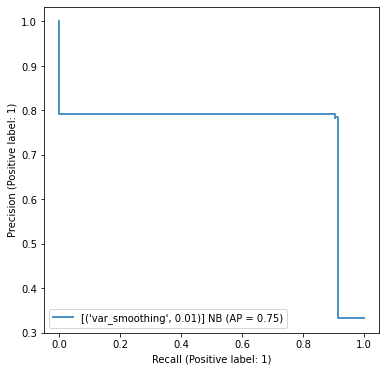

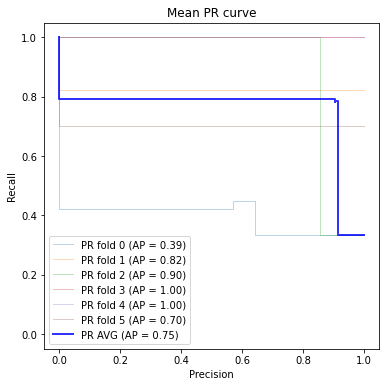

parameter: 0.01
Here are the recall scores: [0.57142857 1.         0.85714286 1.         1.         1.        ]
Here are the precisions scores: [0.42105263 0.82352941 1.         1.         1.         0.7       ]
Here are the accuracies scores: [0.5952381  0.92857143 0.95238095 1.         1.         0.85714286]
Here are the f1 scores: [0.48484848 0.90322581 0.92307692 1.         1.         0.82352941]


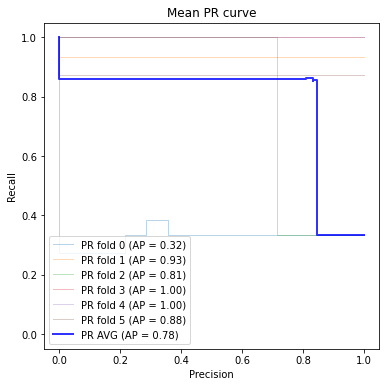

parameter: 0.1
Here are the recall scores: [0.28571429 1.         0.64285714 1.         1.         1.        ]
Here are the precisions scores: [0.33333333 0.93333333 1.         1.         1.         0.875     ]
Here are the accuracies scores: [0.57142857 0.97619048 0.88095238 1.         1.         0.95238095]
Here are the f1 scores: [0.30769231 0.96551724 0.7826087  1.         1.         0.93333333]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


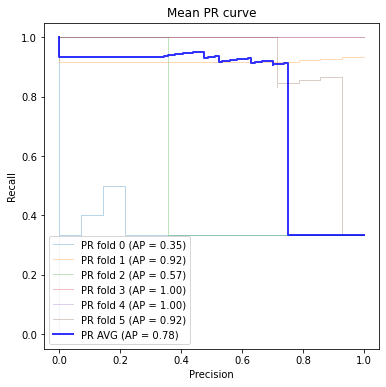

parameter: 1
Here are the recall scores: [0.         0.78571429 0.         0.5        0.42857143 0.42857143]
Here are the precisions scores: [0.         0.91666667 0.         1.         1.         1.        ]
Here are the accuracies scores: [0.64285714 0.9047619  0.66666667 0.83333333 0.80952381 0.80952381]
Here are the f1 scores: [0.         0.84615385 0.         0.66666667 0.6        0.6       ]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


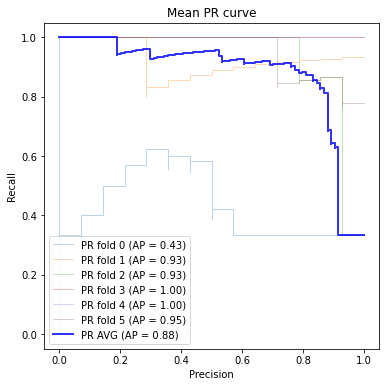

parameter: 3
Here are the recall scores: [0.         0.21428571 0.         0.28571429 0.07142857 0.28571429]
Here are the precisions scores: [0. 1. 0. 1. 1. 1.]
Here are the accuracies scores: [0.66666667 0.73809524 0.66666667 0.76190476 0.69047619 0.76190476]
Here are the f1 scores: [0.         0.35294118 0.         0.44444444 0.13333333 0.44444444]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


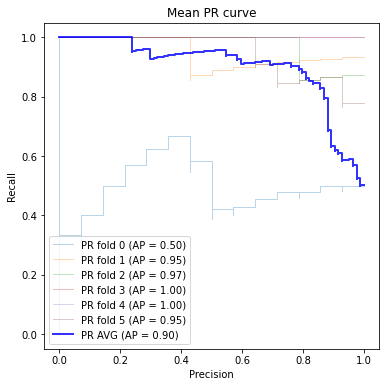

parameter: 6
Here are the recall scores: [0.         0.07142857 0.         0.28571429 0.         0.14285714]
Here are the precisions scores: [0. 1. 0. 1. 0. 1.]
Here are the accuracies scores: [0.66666667 0.69047619 0.66666667 0.76190476 0.66666667 0.71428571]
Here are the f1 scores: [0.         0.13333333 0.         0.44444444 0.         0.25      ]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


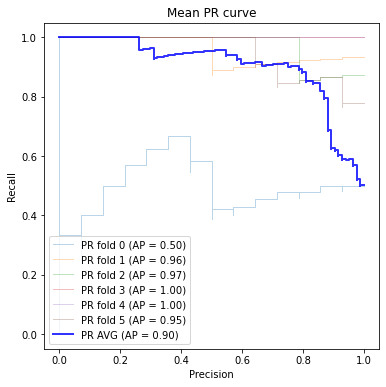

parameter: 10
Here are the recall scores: [0.         0.07142857 0.         0.28571429 0.         0.14285714]
Here are the precisions scores: [0. 1. 0. 1. 0. 1.]
Here are the accuracies scores: [0.66666667 0.69047619 0.66666667 0.76190476 0.66666667 0.71428571]
Here are the f1 scores: [0.         0.13333333 0.         0.44444444 0.         0.25      ]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classi

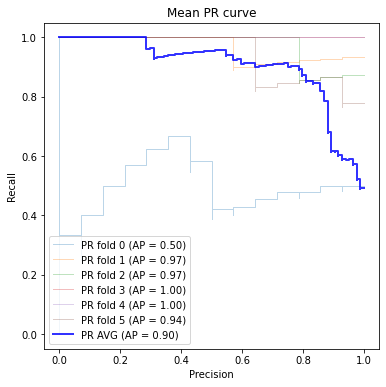

parameter: 100
Here are the recall scores: [0.         0.         0.         0.28571429 0.         0.14285714]
Here are the precisions scores: [0. 0. 0. 1. 0. 1.]
Here are the accuracies scores: [0.66666667 0.66666667 0.66666667 0.76190476 0.66666667 0.71428571]
Here are the f1 scores: [0.         0.         0.         0.44444444 0.         0.25      ]


c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\line\.conda\envs\cloned_CNN2\lib\site-packages\sklearn\metrics\_classi

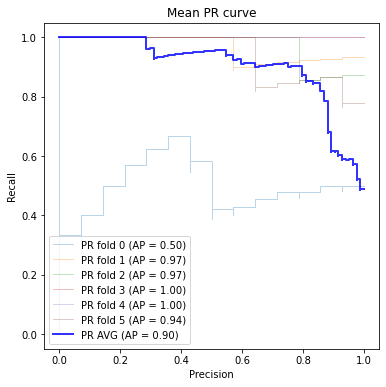

parameter: 1000
Here are the recall scores: [0.         0.         0.         0.07142857 0.         0.        ]
Here are the precisions scores: [0. 0. 0. 1. 0. 0.]
Here are the accuracies scores: [0.66666667 0.66666667 0.66666667 0.69047619 0.66666667 0.66666667]
Here are the f1 scores: [0.         0.         0.         0.13333333 0.         0.        ]


In [6]:
fig2, ax2 = plt.subplots(figsize=(6, 6))
# Example of the model in action
kf = KFold(n_splits=6, shuffle=False)
gridsearch = [1e-2,1e-1,1,3,6,10,100,1000]
for smooth in gridsearch:
    params = {
            'var_smoothing': smooth,
        }
    scores = score_model_PR(GaussianNB,X_OCT,y_labels,params = params, cv=kf,plotMatrix = False, plotROC = True,ax2 = ax2,modelname = 'NB')
    print("parameter:", smooth)
    print(f'Here are the recall scores: {scores[::4]}')
    print(f'Here are the precisions scores: {scores[1::4]}')
    print(f'Here are the accuracies scores: {scores[2::4]}')
    print(f'Here are the f1 scores: {scores[3::4]}')
plt.show()